In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

In [3]:
# There're some restaurants, customers can make reviews to show whether they like the restaurant or not

In [4]:
stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms(multiple restaurants) are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

In [5]:
# Thompson Sampling with and without Beta distribution

In [6]:
# Beta distribution

In [7]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward


In [8]:
# Thompson Sampling with Beta distribution

In [9]:
class ThompsonBeta(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson-beta'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.normal(self.alpha, self.beta)
    return theta.argmax()

In [10]:
# Thompson Sampling without Beta distribution

In [11]:
import math
class NormalAlgo():
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.mean = np.zeros(self.arm_count)
    self.std = np.zeros(self.arm_count)
    self.n = np.zeros(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.n[arm]+=1
    old_mean = self.mean[arm]
    new_mean = (self.mean[arm]*(self.n[arm]-1) + reward)/self.n[arm]
    self.mean[arm] = new_mean

    old_var = np.power(self.std[arm],2)
    if((self.n[arm]-1)!=0):
      new_var = ((self.n[arm]-2)/(self.n[arm]-1))*old_var + (math.pow((reward-old_mean),2))/self.n[arm]
    else:
      new_var = ((self.n[arm]-2))*old_var + (math.pow((reward-old_mean),2))/self.n[arm]
    self.std[arm] = math.sqrt(new_var)


In [12]:
class ThompsonNoBeta(NormalAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson-no-beta'
  
  def get_action(self):
    theta = np.random.normal(self.mean, self.std)
    return theta.argmax()

In [13]:
# e-greedy

In [14]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule
 

In [15]:
# UCB

In [16]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [17]:
# Random Sampling

In [18]:
# author:yiyundotchen
class RandomSampling():
  def __init__(self, bandit):
    self.bandit = bandit
    self.arm_count = bandit.arm_count
  
  @staticmethod
  def name():
    return 'random-sampling'
  
  def get_action(self):
    action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    return reward, regret

In [19]:
# Data, names are lists of vectors

In [20]:
def multi_plot_data(data, names):
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()

In [21]:
# Simulates the algorithm over 'simulations' epochs

In [22]:
def simulate(simulations, timesteps, arm_count, Algorithm):
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

In [23]:
# The experiment function runs the simulations over all algorithms and plots their mean regrets

In [24]:
# author:yiyundotchen

def experiment(arm_count,algos, timesteps=1000, simulations=1000):
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

In [25]:
# Q1:Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important (15 Points) 

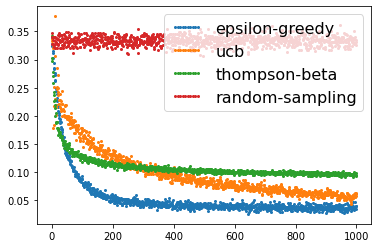

In [26]:
# Baseline
algos = [EpsilonGreedy, UCB, ThompsonBeta, RandomSampling]
arm_count = 5 # number of restaurants
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count,algos)

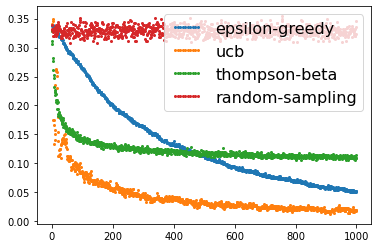

In [27]:
# Greedier
arm_count = 5 
epsilon = 0.01
ucb_c = 1
stationary=True
experiment(arm_count,algos)

In [28]:
# Random Sampling : No hyperparameters
# Thompson Sampling : No hyperparameters
# e-greedy : epsilon is the parameter
# UCB : confidence(ucb_c) is the parameter
# So the only hyperparameters are epsilon and c
# Now we changed epsilon and ucb_c to see the difference.
# For e-greedy:
# When epsilon=0.1,e-greedy can be stabilized at about 200 times,but when epsilon=0.01,e-greedy can be stabilized after 1000 times
# For UCB:
# When c=2,UCB can be stabilized after 1000 times,but when c=1,UCB performs much better and can be stabilized at about 400 times


In [29]:
# Q2:How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points) 

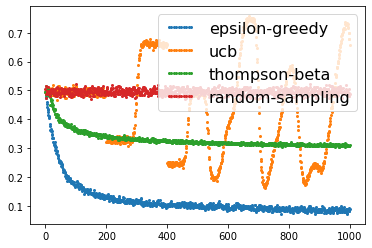

In [30]:
# Large action space
arm_count = 200 
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count,algos)

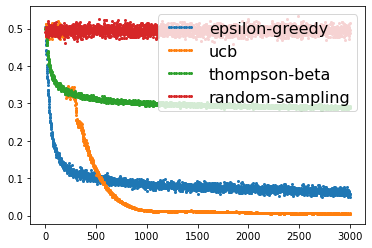

In [31]:
# Large action space with higher timesteps
arm_count = 200 
epsilon = 0.1
ucb_c = 0.1
stationary=True
experiment(arm_count,algos,timesteps=3000,simulations=1000)

In [32]:
# Random Sampling : Less affected
# Thompson Sampling : Slow convergence with larger action space
# e-greedy : Less affected
# UCB : Really erratic,needs higher timesteps and lower c

In [33]:
# Q3:How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points) 

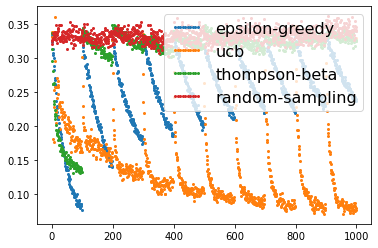

In [34]:
# Non-stationarity
arm_count = 5 
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count,algos)

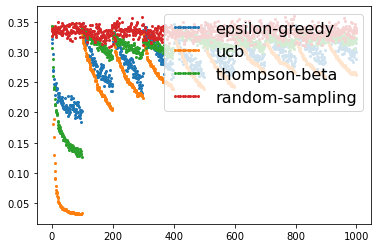

In [35]:
# Non-stationarity with different hyperparameters
arm_count = 5 
epsilon = 0.6
ucb_c = 0.1
stationary=False
experiment(arm_count,algos)

In [36]:
# Random Sampling : Less affected
# Thompson Sampling : Regret value reduce after each reset,but the overall minimum regret is increasing gradually
# e-greedy : Regret value reduce after each reset,but the overall minimum regret is increasing gradually.With different epsilon,e-greedy performs the same.
# UCB : Regret value reduce after each reset,the overall minimum regret is decreasing gradually,performs much better.When c decrease, UCB performs worse.

In [37]:
# Q4:When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff (15 Points) 

In [38]:
# Random Sampling : Always exploring as the sampling is random
# Thompson Sampling : Keep exploring till the simulation is done. It's a good algorithm as it has a chance of exploring at the very end and changing the beta distribution.
# e-greedy : It exploits epsilon% of the time and doesnt stop exploring till the simulation is done.(So epsilon=0 means never explore)
# UCB : When simulation is done.
# Exploration-Exploitation tradeoff : When faced with several competing alternatives, decision-makers must often choose between a known good alternative (exploitation) and one or more unknown but potentially more rewarding alternatives (exploration).

In [39]:
# Q5:How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer. (10 Points) 

In [40]:
# Random Sampling : Doesnt remember the past actions because it's completely random.
# Thompson Sampling : Remembers past actions as long as it is running in the beta distribution to make an action.
# e-greedy : When it needs the past action data to exploit.
# UCB : The same as e-greedy.

In [41]:
# Q6:Thompson Sampling with non-Beta distribution (5 Points) Modify the Thompson Sampling to run with a different distribution (e.g. Parteo, Normal, etc)

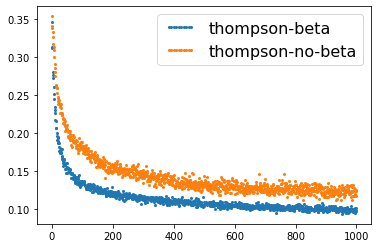

In [42]:
# author:yiyundotchen
algos = [ThompsonBeta, ThompsonNoBeta]
arm_count = 5 
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count,algos)

In [43]:
# Q7:What code is yours and what have you adapted? (10 Points)

In [44]:
# I wrote codes which I added # author:yiyundotchen on the first line of cell:the Random Sampling part and modified the experiment part.
# I wrote the code for Normal Distribution Thompson Sampling based on existing codes
# Else codes are changed or cited based on following references.
# References:
# https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb
# https://lilianweng.github.io/posts/2018-01-23-multi-armed-bandit/
# https://en.wikipedia.org/wiki/Normal_distribution

In [46]:
# License
# MIT License

# Copyright (c) 2022 Yiyun Chen

# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.